In [11]:
import numpy as np
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm

from main import main_data_loader

train_dataloader, val_dataloader, test_dataloader = main_data_loader(24)
model = torch.load("保留模型/1/BiLSTM_softmax_24_8.pth", map_location="cpu")

model.eval()  # 设置为评估模式
true_labels = []
predicted_probs = []
# 对测试数据进行预测
with torch.no_grad():
    for item in tqdm(val_dataloader):
        data, targets = item
        data = data.float()
        targets = targets.long()
        outputs = model(data).float()
        true_labels.append(targets.numpy())
        predicted_probs.append(outputs.numpy())
predicted_probs_flat = np.concatenate(predicted_probs)  # 将所有预测概率展平成一个数组
true_labels_flat = np.concatenate(true_labels)  # 将所有真实标签展平成一个数组
fpr, tpr, thresholds = roc_curve(true_labels_flat, predicted_probs_flat)
roc_auc = auc(fpr, tpr)

100%|██████████| 372/372 [00:24<00:00, 14.93it/s]


In [12]:
# 选择最佳阈值
best_threshold_index = (1 * tpr - fpr).argmax()
best_threshold = thresholds[best_threshold_index]

AUC: 0.8044099801715592
Best threshold: 0.46168622


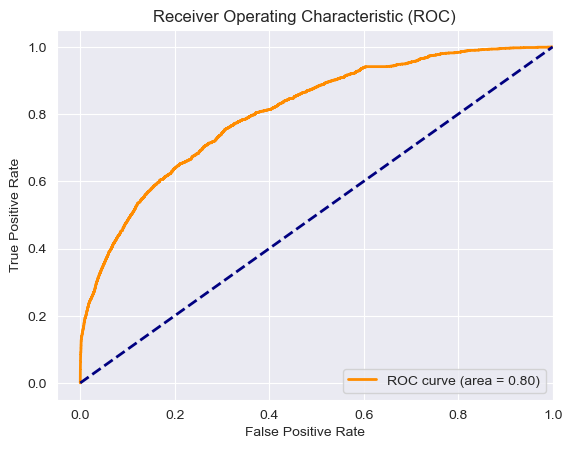

In [13]:

print("AUC:", roc_auc)
print("Best threshold:", best_threshold)
# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [14]:
TP = np.sum((predicted_probs_flat > best_threshold) & (true_labels_flat == 1))
FP = np.sum((predicted_probs_flat > best_threshold) & (true_labels_flat == 0))
TN = np.sum((predicted_probs_flat <= best_threshold) & (true_labels_flat == 0))
FN = np.sum((predicted_probs_flat <= best_threshold) & (true_labels_flat == 1))

confusion_matrix = np.array([[TN, FP], [FN, TP]])
print("Confusion Matrix:")
print(confusion_matrix)

Confusion Matrix:
[[64354 28483]
 [  552  1699]]


In [15]:
specificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)
accuracy = (TP + TN) / (TP + TN + FP + FN)

print("Specificity:", specificity)
print("Sensitivity:", sensitivity)
print("Accuracy:", accuracy)

Specificity: 0.6931934465784116
Sensitivity: 0.754775655264327
Accuracy: 0.6946512704021538


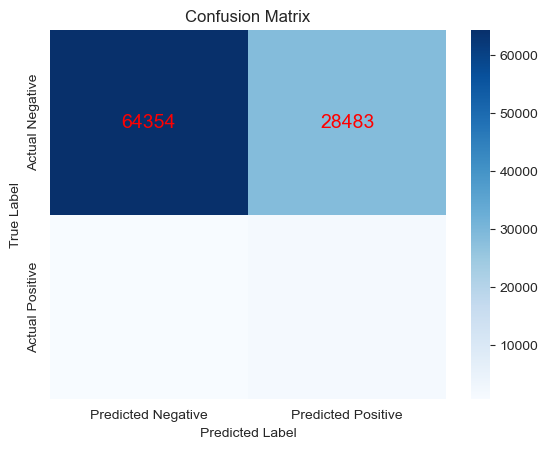

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制混淆矩阵
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"],
            annot_kws={"size": 14, "color": 'red'})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [2]:
from model import BiLSTM_BN
from torchviz import make_dot
import torch
import os

model = BiLSTM_BN()
dummy_input = torch.randn(128, 24, 7)  # 1个样本，3个通道，32x32的图像
os.environ["PATH"] += os.pathsep + 'E:/Graphviz-11.0.0-win64/bin'  # 替换成你的路径

# 生成模型的计算图
dot = make_dot(model(dummy_input), params=dict(model.named_parameters()))

# 保存为图片
dot.render("model_structure", format="png")

'model_structure.png'

In [4]:
import json

# 定义超参数
hyperparameters = {
    "BATCH_SIZE": 256,
    "EPOCH": 20,
    "LR": 0.001,
    "GAMMA": 0,
    "STEP_SIZE": 10,
    "device": "cuda"
}
data_idx = 20
model_name = f"BiLSTM_BN_lesssample_{data_idx}"

# 将超参数保存到JSON文件
with open(f'./{model_name}/hyperparameters.json', 'w') as json_file:
    json.dump(hyperparameters, json_file, indent=4)
